In [56]:
import matplotlib.pyplot as plt
import matplotlib
# %matplotlib qt

import numpy as np
from numpy import *
from scipy.fft import fft, ifft, fftshift, ifftshift
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
import os
import scipy.io as sio

def psd_full(f, A1, A2, C):
    return A1 / f + A2 / f**2 + C

# Fitting function
def get_full_fit(x_data, y_data):
    valid = (x_data > 0) & (y_data > 0) & np.isfinite(y_data)
    x_clean = x_data[valid]
    y_clean = y_data[valid]
    params, pcov = curve_fit(psd_full, x_clean, y_clean, maxfev=10000)
    A1, A2, C = params
    a1_err = np.sqrt(pcov[0, 0])
    return A1, A2, C, x_clean, y_clean, a1_err

In [57]:
initial_folder = r'C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise_9\VNA_power_sweep'

folders = os.listdir(initial_folder)
for i in range(len(folders)):
    if ".fig" in folders[i]: pass
    else: 
        print(r"[%d]" %(i), '----------->', folders[i])

[0] -----------> 00Nois_swep_10mK_low_band_10_avg_100_nop_501_vna_power_only_-50 _2025-08-01-05-34-44.mat
[1] -----------> 01Nois_swep_10mK_low_band_10_avg_100_nop_501_vna_power_only_-40 _2025-08-01-02-43-02.mat
[2] -----------> 02Nois_swep_10mK_low_band_10_avg_100_nop_501_vna_power_only_-30 _2025-07-31-23-51-19.mat
[3] -----------> 03Noise_sweep_10mK_low_band_5_avg_50_nop_501_vna_power_only_-20.0_2025-07-31-10-50-28.mat
[4] -----------> 04Noise_sweep_10mK_low_band_5_avg_50_nop_501_vna_power_only_-19.0_2025-07-31-12-16-22.mat
[5] -----------> 05Noise_sweep_10mK_low_band_5_avg_50_nop_501_vna_power_only_-18.0_2025-07-31-13-42-16.mat
[6] -----------> 06Noise_sweep_10mK_low_band_5_avg_50_nop_501_vna_power_only_-17.0_2025-07-31-15-08-10.mat
[7] -----------> 07Noise_sweep_10mK_low_band_5_avg_50_nop_501_vna_power_only_-16.0_2025-07-31-16-34-03.mat
[8] -----------> 08Noise_sweep_10mK_low_band_5_avg_50_nop_501_vna_power_only_-15.0_2025-07-31-17-59-57.mat
[9] -----------> 09Noise_sweep_10mK_low_

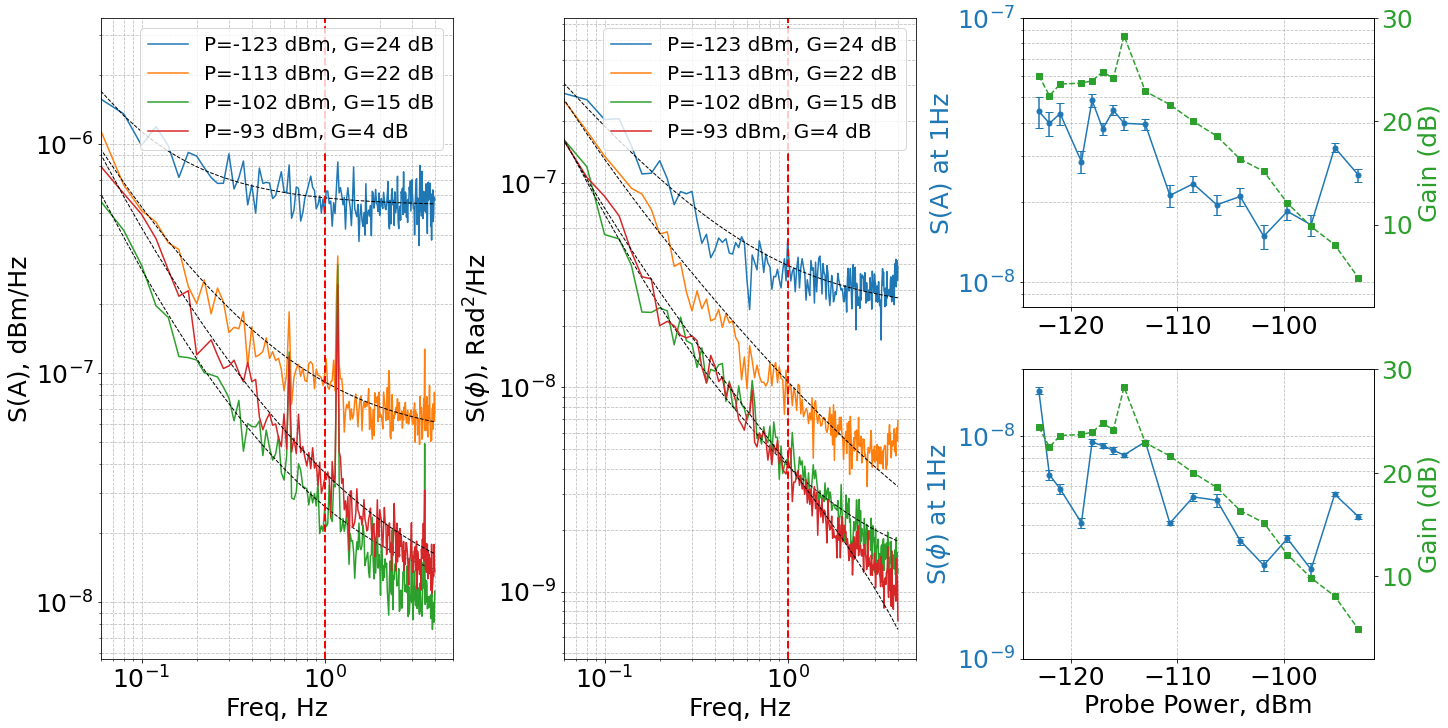

In [61]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import numpy as np
import scipy.io as sio
from scipy.optimize import curve_fit
from matplotlib.ticker import LogLocator, MultipleLocator

# PSD model: 1/f + 1/f^2 + white noise
def psd_full(f, A1, A2, C):
    return A1 / f + A2 / f**2 + C

# Fitting function
def get_full_fit(x_data, y_data):
    valid = (x_data > 0) & (y_data > 0) & np.isfinite(y_data)
    x_clean = x_data[valid]
    y_clean = y_data[valid]
    lower_bounds = [0, 0, 0]
    upper_bounds = [np.inf, np.inf, np.inf]
    params, pcov = curve_fit(psd_full, x_clean, y_clean, maxfev=10000,bounds=(lower_bounds, upper_bounds))
    A1, A2, C = params
    a1_err = np.sqrt(pcov[0, 0])
    return A1, A2, C, x_clean, y_clean, a1_err

# Set font
font = {'size': 25}
matplotlib.rc('font', **font)

# Plot layout
fig = plt.figure(figsize=(20, 10), constrained_layout=True)
gs = gridspec.GridSpec(2, 3, figure=fig)
ax0 = fig.add_subplot(gs[0:2, 0])
ax1 = fig.add_subplot(gs[0:2, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 2])

# Initialize results
a_pha = np.array([])
a_mag = np.array([])
a_pha_err = np.array([])
a_mag_err = np.array([])
c_pha = np.array([])
c_mag = np.array([])
c_pha_err = np.array([])
c_mag_err = np.array([])
VNA_powers = np.array([])
gain = np.array([])

# BANDWIDTH WAS 10 Hz
BW = 10  # As per your note

# Indices to highlight
idx_set = [3, 12, 17, 21]

for i in range(len(folders)):
    if i in [0, 1, 2, 6]:
        continue
    file = folders[i]
    power_dbm = float(folders[i][60:64])
    VNA_powers = np.append(VNA_powers, power_dbm)

    mat = sio.loadmat(initial_folder + "\\" + file)
    data_gain = mat['data_gain'][0, 0]
    gain = np.append(gain, data_gain)

    fft_freq = mat['fft_freq'][0]
    data_mag = mat['data_mag'][0, 0, 0] / len(fft_freq) / BW * 2
    data_pha = mat['data_pha'][0, 0, 0] / len(fft_freq) / BW * 2

    data_mag_mea = data_mag[1]
    data_pha_mea = data_pha[1]

    # PHASE
    try:
        A1, A2, C, xc_full, yc_full, a_err = get_full_fit(fft_freq[-249:-50], data_pha_mea[-249:-50])
        if i in idx_set:
            ax0.plot(xc_full, yc_full, '-', markersize=2, label=f'P={int(power_dbm)-103} dBm, G={int(data_gain)} dB')
        y_fit = psd_full(xc_full, A1, A2, C)
        if i in idx_set:
            ax0.plot(xc_full, y_fit, 'k--', linewidth=1)
        a_pha = np.append(a_pha, A1)
        c_pha = np.append(c_pha, C)
        a_pha_err = np.append(a_pha_err, a_err)
    except Exception as e:
        print(f"Phase fit failed at i={i}: {e}")

    # MAGNITUDE
    try:
        A1, A2, C, xc_full, yc_full, a_err = get_full_fit(fft_freq[-249:-50], data_mag_mea[-249:-50])
        if i in idx_set:
            ax1.plot(xc_full, yc_full, '-', markersize=2, label=f'P={int(power_dbm)-103} dBm, G={int(data_gain)} dB')
        y_fit = psd_full(xc_full, A1, A2, C)
        if i in idx_set:
            ax1.plot(xc_full, y_fit, 'k--', linewidth=1)
        a_mag = np.append(a_mag, A1)
        c_mag = np.append(c_mag, C)
        a_mag_err = np.append(a_mag_err, a_err)
    except Exception as e:
        print(f"Magnitude fit failed at i={i}: {e}")

# Draw vertical line at 1 Hz
for ax in [ax0, ax1]:
    ax.axvline(1, color='red', linestyle='--', linewidth=2)
    ax.set_xlim(left=fft_freq[-248], right=fft_freq[-1])
    ax.grid(True, which='both', linestyle='--', alpha=0.8)
    ax.legend(fontsize=20)
    ax.set_xscale('log', base=10)
    ax.set_yscale('log', base=10)

    
# Sort all data by VNA_powers
combined_data = list(zip(VNA_powers, a_pha, a_mag, gain, a_pha_err, a_mag_err, c_pha, c_mag, c_pha_err, c_mag_err))
combined_data.sort()
VNA_powers, a_pha, a_mag, gain, a_pha_err, a_mag_err = map(np.array, zip(*combined_data))

# Plot noise at 1Hz with error bars
ax2.errorbar(VNA_powers-103, a_pha, yerr=a_pha_err, fmt='o-', markersize=5, capsize=4, color='tab:blue')
ax3.errorbar(VNA_powers-103, a_mag, yerr=a_mag_err, fmt='o-', markersize=5, capsize=4, color='tab:blue')

# Plot gain on secondary y-axis
ax2_gain = ax2.twinx()
ax2_gain.plot(VNA_powers-103, gain, 's--', color='tab:green')
ax2_gain.set_ylabel('Gain (dB)', color='tab:green')
ax2_gain.tick_params(axis='y', labelcolor='tab:green', labelsize=25)

ax3_gain = ax3.twinx()
ax3_gain.plot(VNA_powers-103, gain, 's--', color='tab:green')
ax3_gain.set_ylabel('Gain (dB)', color='tab:green')
ax3_gain.tick_params(axis='y', labelcolor='tab:green', labelsize=25)

# Axis labels
ax0.set_ylabel('S(A), dBm/Hz')
ax1.set_ylabel(r'S($\phi$), Rad$^2$/Hz')
ax0.set_xlabel('Freq, Hz')
ax1.set_xlabel('Freq, Hz')

ax2.set_ylabel('S(A) at 1Hz', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

ax3.tick_params(axis='y', labelcolor='tab:blue')
ax3.set_ylabel(r'S($\phi$) at 1Hz', color='tab:blue')

ax3.set_xlabel('Probe Power, dBm')



# Axis scales
ax2.set_yscale('log', base=10)
ax3.set_yscale('log', base=10)

# Grid and ticks
for ax in [ax2, ax3]:
    ax.grid(True, which='both', linestyle='--', alpha=0.8)


# ax0.set_ylim(5e-8, 7e-4)
# ax1.set_ylim(8e-9, 1e-2)
ax2.set_ylim(8e-9, 1e-7)
ax3.set_ylim(1e-9, 0.2e-7)
ax3_gain.set_ylim(2, 30)
ax2_gain.set_ylim(2, 30)


# Save and display
plt.savefig(r"C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise_9\paper_plots\Power_sweep_VNA.png", dpi=300, bbox_inches='tight')
plt.show()
